# Scan of Quality Factor at multiple power levels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
import HelpModule  as help

from E5080B_driver import *
from SGS100A_driver import *
from spirack import SPI_rack, S4g_module
from IPython.display import clear_output
from time import sleep
import fitting as fit
from datetime import datetime

from importlib import reload

twpa_on = False
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()

if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
    twpa.open()

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [3]:
# Set the test paramteres
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'resonatorquality'
params['qubit_name'] = 'NbT015_HMDS_S2-R1'
params['twpa_on'] = twpa_on
params['vna_power'] = -60   #<-----------------------------
params['center_freq'] = 4.41554e9
params['span_freq'] = 6 #In MHz
params['flux_curr'] = 0
params['temp'] = 22.7
params['comment'] = "Cavity Quality Factor Measuremnt before Annealing \n" +\
                    "# After Annealing " +\
                    "# " +\
                    "# Connection Diagram: NA" +\
                    "# \n"
params['npoints']  = 24000
params['res_power_start'] = -20
params['res_power_stop'] = -71
params['res_power_step'] = -5


if params['twpa_on']:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm

min_delay = 600
max_delay = 3000

In [4]:
# Measure a high power spetrum

meas = 'S21'
format = 'MA'

freqs, mag, phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['span_freq'], power = params['vna_power'], 
                                  sleep_t = 90, npoints = params['npoints'], data_format = format, meas = meas)
vna.autoscale()

reload(help)

idx0 = 0
idx1 = -1
f_c, Qf, fwhm = help.Q(freqs[idx0:idx1],mag[idx0:idx1], format='MA', plot_f=True)

print('Quality Factor: %2.3f'%Qf)
print('3dB BW: %2.3f kHz'%(fwhm*1e-3))
print('f_c: %2.5f GHz'%(f_c*1e-9))

Quality Factor: 35552.596
3dB BW: 124.197 kHz
f_c: 4.41554 GHz


Using the measured spectrum we will do a first iteration of fitting the complex and real parts to the following function
$$
    S_{21}(\omega) =  A \cdot \left( 1- \frac{Q/Q_e \cdot e^{i \theta}}{1+2iQ\frac{\omega-\omega_c}{\omega_c}} \right)
    \left( 1+\alpha\frac{\omega-\omega_c}{\omega_c}   \right)
    e^{j(\phi_v \cdot \omega + \phi_0)}

$$
We will use these parameters for the follwing fittings, but normally a first good guess needs to be found manually. Changing the initial electrical delay for isntance helps removing the background phase disperssion, although this can be removed directly by setting the vna's electrical delay parameter, a small adjustment in this parameter helps to get a cleaner fitting. The phi0 parameter also helps change the starting point of the phase component of the dataset.

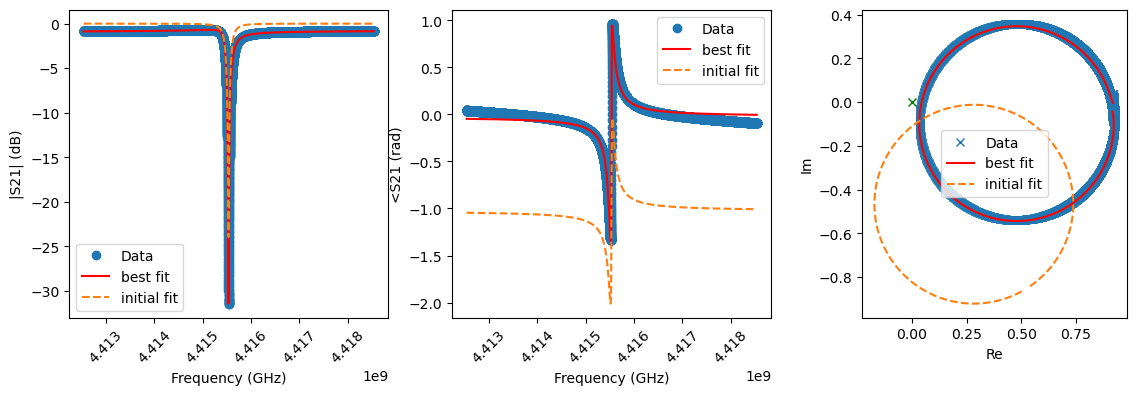

{'f_c': 4415523398.320419, 'Q': 33443.88401456934, 'Qe': 34457.04382351476, 'A': 0.9175906463583122, 'A0': 0, 'slope': 7.617471296555365, 'theta': 0.19469571954538445, 'phi_v': 8.890665981198254e-11, 'phi_v0': 929.4934889370452, 'Qi': 700520.9937574324, 'fwhm': 132027.82895661463, 'kc': 0.12814574056138567}
R^2 = (-0.20161862379630136+4.651953505406009j)


In [19]:
reload(fit)

angle_rad = np.unwrap(phase*np.pi/180)+np.pi*0.35
s21 = np.array((mag)*np.exp(1j*angle_rad),dtype=np.complex128) #dtype = # 128-bit complex floating-point number                 

#Unwind phase
tau = 0.012 #electrical delay in ns (first guess from VNA measure)
phi0 = -np.pi/2 #+np.pi/2
A0 = 1
zdata = np.array(s21*np.exp(1j*(freqs*tau*1e-9*2*np.pi+phi0)),dtype=np.complex128)*A0

fit0= fit.circle_fit(freqs, zdata, f_c = f_c, fwhm = fwhm, Qe = Qf*1.1, plot=True)
best_values = fit0[0]
print(best_values)
print("R^2 = "+str(fit0[2]))
#print(f_report)

In [7]:
#create power array
powersweep_array = np.arange(params['res_power_start'],params['res_power_stop'],params['res_power_step'])

#Create delay array
delays = np.ndarray(len(powersweep_array))
delays[:] = np.round(np.logspace(np.log10(min_delay),np.log10(max_delay),num=len(delays), base=10),2)

#Storage arrays
mags = np.ndarray((len(powersweep_array),params['npoints']))
phases = np.ndarray((len(powersweep_array),params['npoints']))

mags[:] = 0
phases[:] = 0

Qls = np.ndarray(len(powersweep_array))
Qes = np.ndarray(len(powersweep_array))
Qis = np.ndarray(len(powersweep_array))
kcs = np.ndarray(len(powersweep_array))

Qls[:]=0
Qis[:]=0
Qes[:]=0
kcs[:]=0

#Estimate test tme
fitting_time = 1
time = np.sum(delays)+(fitting_time)*len(delays)
print('Estimated time is %2.2f min'%(time/60))


Estimated time is 279.25 min


In [8]:
#Gather all Data
import matplotlib.pyplot as plt
from IPython.display import clear_output
from plotly.subplots import make_subplots
import plotly.graph_objects  as plt 
from tqdm.notebook  import tqdm

freqs = vna.get_freq_array()

try:
        for idx in tqdm(range(len(powersweep_array))):
                res_power = powersweep_array[idx]
                vna.set_power(res_power,overule_power=True)
                vna.reset_average()
                with (run(vna)):
                        sleep(delays[idx])
                        mag, phase =  vna.get_data()
                mags[idx] = mag
                phases[idx] = phase
finally:
        header_str = get_plot_str(params)
        filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
        np.savez("./data/NbT015_HMDS/"+filename,
                header = header_str,
                freqs=freqs,
                mags=mags,
                phases=phases,
                power=powersweep_array)
        print('file saved as %s'%filename)

  0%|          | 0/11 [00:00<?, ?it/s]

file saved as resonatorquality_NbT015_HMDS_S2-R1_20240715_1852


In [47]:
# Fit for all measurements
reload(fit)


for idx in tqdm(range(len(powersweep_array))):
        res_power = powersweep_array[idx]
        mag = mags[idx]
        phase = phases[idx]

        angle_rad = np.unwrap(phase*np.pi/180)
        s21 = np.array((mag)*np.exp(1j*angle_rad),dtype=np.complex128)#dtype = # 128-bit complex floating-point number                 

        #Unwind phase
        zdata = np.array(s21*np.exp(1j*(freqs*tau*1e-9*2*np.pi+phi0)),dtype=np.complex128)*A0
        fit_results = fit.circle_fit(freqs, zdata, 
                                        f_c = fit0[0]['f_c'],
                                        fwhm = fit0[0]['fwhm'], 
                                        Qe_max=fit0[0]['Qe']*1.1, 
                                        Qe_min= fit0[0]['Qe']*0.9,
                                        plot=False)
        
        Qls[idx] = fit_results[0]['Q']
        Qes[idx] = fit_results[0]['Qe']
        Qis[idx] = fit_results[0]['Qi']
        kcs[idx] = fit_results[0]['kc']

        #Plot and print results
        clear_output()
        print(fit_results)
        fig = make_subplots(rows=1, cols=2, subplot_titles=("Qe","Qi"))
        fig.add_trace(plt.Scatter(x=powersweep_array,y=Qes))
        fig.add_trace(plt.Scatter(x=powersweep_array,y=Qis),row=1,col=2)
        fig.show()

({'f_c': 4415523398.320419, 'Q': 33443.88401456945, 'Qe': 33443.88401456934, 'A': 0.9999999999999998, 'A0': 0, 'slope': 0.0, 'theta': 0.0, 'phi_v': 0.0, 'phi_v0': 288.0, 'Qi': -1.0177513971701821e+19, 'fwhm': 132027.82895661422, 'kc': 0.13202782895661463}, <lmfit.model.ModelResult object at 0x000002752C4A0CD0>, -4.8133632732585606e+17)


In [46]:
print(fit0[2])

(-0.20161862379630136+4.651953505406009j)


In [27]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as plt 

Qe_threshold = fit0['Qe']*1.05
fig = make_subplots(rows=1, cols=2, subplot_titles=("Qe","Qi"))
fig.add_trace(plt.Scatter(x=powersweep_array[Qes<Qe_threshold],y=Qes[Qes<Qe_threshold]))
fig.add_trace(plt.Scatter(x=powersweep_array[Qes<Qe_threshold],y=Qis[Qes<Qe_threshold]),row=1,col=2)
fig.show()

print('Power \t kc \t Qi \t\tQe ')
for p, k, qi, qe in zip(powersweep_array[Qes<Qe_threshold], kcs[Qes<Qe_threshold], Qis[Qes<Qe_threshold],Qes[Qes<Qe_threshold]):
    print('%2.1f\t%2.3f \t%2.2e\t%2.2e'%(p,k, qi,qe))



TypeError: tuple indices must be integers or slices, not str

In [11]:
#Export data to csv

import csv, os
#params['qubit_name'] = 'RES_NBS4'

header = ["Freq(Hz)","S21(DB)","S21(DEG)"]

try: os.mkdir("data\\"+params['qubit_name'])
except: pass

for idx, res_power in enumerate(powersweep_array):
        filepath = ".\data\%s\%idBm.csv"%(params['qubit_name'] ,res_power)

        with open(filepath, mode='w', newline='') as file:
                print(filepath)
                mag = mags[idx]
                phase = phases[idx]

                writer = csv.writer(file)
                writer.writerow(["!CSV A.01.01"])
                writer.writerow(['!TII Quantum Research Center - Quantum Computing'])
                writer.writerow(['!Date: %s'%params['test_date']])
                writer.writerow(['!Source: Standard'])
                writer.writerow('')
                writer.writerow(['BEGIN CH1_DATA'])
                writer.writerow(header)
                for (f, m,p) in zip(freqs, mag,phase):
                        if format == 'MA':
                                m = 20*np.log10(m)
                        writer.writerow([f, m,p])

.\data\NbT015_HMDS_S2-R1\-20dBm.csv
.\data\NbT015_HMDS_S2-R1\-25dBm.csv
.\data\NbT015_HMDS_S2-R1\-30dBm.csv
.\data\NbT015_HMDS_S2-R1\-35dBm.csv
.\data\NbT015_HMDS_S2-R1\-40dBm.csv
.\data\NbT015_HMDS_S2-R1\-45dBm.csv
.\data\NbT015_HMDS_S2-R1\-50dBm.csv
.\data\NbT015_HMDS_S2-R1\-55dBm.csv
.\data\NbT015_HMDS_S2-R1\-60dBm.csv
.\data\NbT015_HMDS_S2-R1\-65dBm.csv
.\data\NbT015_HMDS_S2-R1\-70dBm.csv
